In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# G-Research Cryptocurrencies : Modelisation

- Utils.

In [2]:
# system libraries
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import gc

# data manipulation libraries
import pandas as pd
import numpy as np

# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# modelisation libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
def regression_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE, MAPE & R² score  
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse)
    print("MAPE: ", mape.round(5))

In [4]:
path = '/content/drive/My Drive/Ingénieur ML - OC/P8/datasets/new_df/'

## 1) Data Preprocessing

In [5]:
merged_df = pd.read_parquet(path+"bitcoin.parquet.gzip")
print(merged_df)

                    asset_name   count  ...         FRAMA        RSI
timestamp                               ...                         
2018-01-01 00:01:00    Bitcoin   229.0  ...  13850.176000        NaN
2018-01-01 00:02:00    Bitcoin   235.0  ...  13828.102000   0.000000
2018-01-01 00:03:00    Bitcoin   528.0  ...  13801.314000   0.000000
2018-01-01 00:04:00    Bitcoin   435.0  ...  13768.040000   0.000000
2018-01-01 00:05:00    Bitcoin   742.0  ...  13724.914000   0.000000
...                        ...     ...  ...           ...        ...
2021-09-20 23:40:00    Bitcoin  2643.0  ...  42732.110792  42.214157
2021-09-20 23:41:00    Bitcoin  2281.0  ...  42735.206879  46.946353
2021-09-20 23:42:00    Bitcoin  2642.0  ...  42736.037666  45.592383
2021-09-20 23:43:00    Bitcoin  2134.0  ...  42735.569985  43.622163
2021-09-20 23:44:00    Bitcoin  2165.0  ...  42731.713506  40.660711

[1955978 rows x 21 columns]


In [6]:
merged_df.fillna(0, inplace=True)

In [7]:
merged_df.drop(["asset_name", "vwap", "count",
          "open", "close", "high",
          "low", "volume", "log_open",
          "FRAMA", "RSI", "log_close",
          "log_low", "log_high"],
          axis=1, inplace=True)

In [8]:
train_set = merged_df.loc[merged_df.index <= "2021-06-20 23:59:00"]
test_set = merged_df.loc[merged_df.index >= "2021-06-21 00:00:00"]

train_set = train_set.reset_index()
train_set.drop("timestamp", axis=1, inplace=True)

test_set = test_set.reset_index()
test_set.drop("timestamp", axis=1, inplace=True)

y_train = train_set["target"]
X_train = train_set.drop("target", axis=1)

y_test = test_set["target"]
X_test = test_set.drop("target", axis=1)

In [9]:
del train_set,\
    test_set,\
    merged_df
gc.collect()

50

In [10]:
#cat_var = ["asset_name"]
num_var = ["H-L", "O-C", "MA_7d",
           "MA_14d", "MA_21d", "STD_7d"]

In [11]:
"""cat_pipe = Pipeline([
    ('encoder', OneHotEncoder())
])
"""
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler())
])

preprocessing_pipe = ColumnTransformer(
    transformers=[
    #("cat", cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [12]:
X_train = preprocessing_pipe.fit_transform(X_train)

## 2) Modelisation with Machine Learning methods

### a) Linear Regression

In [13]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [14]:
X_test = preprocessing_pipe.transform(X_test)

In [15]:
y_pred = lin_reg.predict(X_test)

In [16]:
regression_metrics(y_test, y_pred)

MAE:  0.00106
MSE:  0.0
RMSE:  0.0015838395125519608
MAPE:  1.38465


In [17]:
del y_pred, lin_reg
gc.collect()

301

### b) Random Forest

In [18]:
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [19]:
y_pred = rf_reg.predict(X_test)
regression_metrics(y_test, y_pred)

MAE:  0.00388
MSE:  4e-05
RMSE:  0.006370210671106686
MAPE:  41.40728


In [20]:
del y_pred,\
    rf_reg,\
    X_train,\
    X_test,\
    y_train,\
    y_test

gc.collect()

148

## 3) Modelisation with Deep Learning methods

### a) ANN according to Vijdha et al. (2020)

In [21]:
from tensorflow import keras
import tensorflow as tf
import datetime

In [22]:
merged_df = pd.read_parquet(path+"bitcoin.parquet.gzip")

In [23]:
merged_df.fillna(0, inplace=True)

In [24]:
merged_df.drop(["asset_name", "vwap", "count",
          "open", "close", "high",
          "low", "volume", "log_open",
          "FRAMA", "RSI", "log_close",
          "log_low", "log_high"],
          axis=1, inplace=True)

In [26]:
train_features = merged_df.loc[merged_df.index <= "2021-06-20 23:59:00"]
train_features = train_features.reset_index()
train_features.drop("timestamp", axis=1, inplace=True)
train_labels = train_features["target"]
train_features = train_features.drop("target", axis=1)
train_features = np.asarray(train_features).astype("float32")

In [27]:
test_features = merged_df.loc[merged_df.index <= "2021-06-20 23:59:00"]
test_features = test_features.reset_index()
test_features.drop("timestamp", axis=1, inplace=True)
test_labels = test_features["target"]
test_features = test_features.drop("target", axis=1)
test_features = np.asarray(test_features).astype("float32")

In [28]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features)

In [29]:
def build_and_compile_model(data):
  model = keras.Sequential([
      data,
      keras.layers.Dense(3, activation="relu"),
      keras.layers.Dense(1)
  ])

  model.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [30]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 3)                 21        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 38
Trainable params: 25
Non-trainable params: 13
_________________________________________________________________


In [31]:
%%time

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split = 0.2,
    verbose = 1, epochs = 100)

Epoch 1/100
45588/45588 [==============================] - 99s 2ms/step - loss: 0.0030 - val_loss: 0.0388
Epoch 2/100
45588/45588 [==============================] - 97s 2ms/step - loss: 0.0012 - val_loss: 0.0392
Epoch 3/100
45588/45588 [==============================] - 98s 2ms/step - loss: 0.0012 - val_loss: 0.0386
Epoch 4/100
45588/45588 [==============================] - 97s 2ms/step - loss: 0.0012 - val_loss: 0.0385
Epoch 5/100
45588/45588 [==============================] - 97s 2ms/step - loss: 0.0012 - val_loss: 0.0387
Epoch 6/100
45588/45588 [==============================] - 97s 2ms/step - loss: 0.0012 - val_loss: 0.0384
Epoch 7/100
45588/45588 [==============================] - 97s 2ms/step - loss: 0.0012 - val_loss: 0.0383
Epoch 8/100
45588/45588 [==============================] - 97s 2ms/step - loss: 0.0012 - val_loss: 0.0390
Epoch 9/100
45588/45588 [==============================] - 96s 2ms/step - loss: 0.0012 - val_loss: 0.0387
Epoch 10/100
45588/45588 [====================

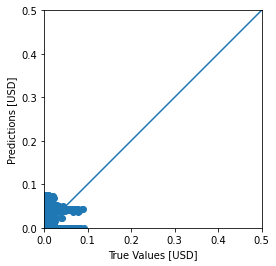

In [32]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [USD]')
plt.ylabel('Predictions [USD]')
lims = [0, 0.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

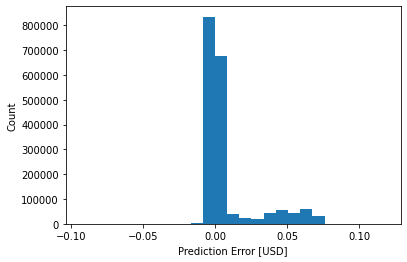

In [33]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [USD]')
_ = plt.ylabel('Count')

In [34]:
regression_metrics(test_predictions, test_labels)

MAE:  0.00865
MSE:  0.00041
RMSE:  0.020194156854426576
MAPE:  3.75151
